# Use OSMnx to plot street network over place shape

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

ox.__version__

'2.0.2'

This example uses Portland, Maine - a city with several islands within its municipal boundaries. Thus, we set `retain_all=True` when getting the network so that we keep all the graph components, not just the largest connected component.

In [2]:
# get the place boundaries
place = "Portland, Maine"
gdf = ox.geocoder.geocode_to_gdf(place)

# get the street network, with retain_all=True to retain all the disconnected islands' networks
G = ox.graph.graph_from_place(place, network_type="drive", retain_all=True)

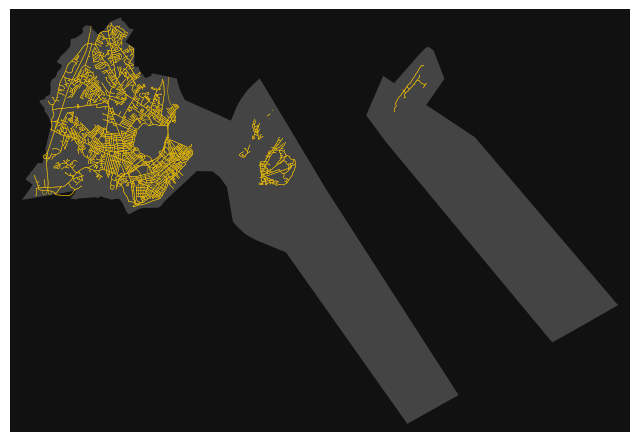

In [3]:
# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    G,
    show=False,
    close=False,
    bgcolor="#111111",
    edge_color="#ffcb00",
    edge_linewidth=0.3,
    node_size=0,
)

# to this matplotlib axis, add the place shape(s)
gdf.plot(ax=ax, fc="#444444", ec=None, lw=1, alpha=1, zorder=-1)

# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.union_all().bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()

Notice this municipal boundary is an administrative boundary, not a physical boundary, so it represents jurisdictional bounds, not individual physical features like islands. To retrieve individual islands' geometries, use the `features` module to search for features matching certain OSM tags:

In [4]:
islands = ox.features.features_from_place(place, tags={"place": ["island", "islet"]})
islands.shape

(27, 16)

## How do you remove the water and just get a coastal city's land?

OpenStreetMap maps coastlines rather than water, so the task isn't as straightforward as "download the political boundary, then subtract the water from it." Instead, the workflow is to get the political boundary and coastlines as linestrings, polygonize them, then drop the resulting water polygon.

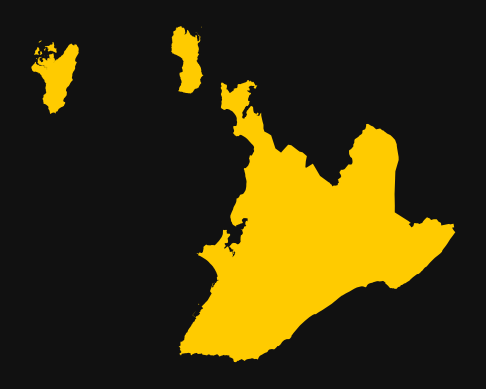

In [5]:
# get all municipalities and coastlines within Salvador
place = "Salvador, Bahía, Brasil"
tags = {"natural": "coastline", "place": "municipality"}
gdf = ox.features.features_from_place(place, tags)

# project and filter results to keep only Salvador municipality and coastlines
mask1 = gdf["name"] == "Salvador"
mask2 = gdf["natural"] == "coastline"
gdf = ox.projection.project_gdf(gdf.loc[mask1 | mask2])

# replace Salvador municipal boundary polygon with boundary linestring
gdf.loc[mask1, "geometry"] = gdf.loc[mask1, "geometry"].boundary

# polygonize the linestrings, drop the largest polygon (open water)
gdf_land = gpd.GeoDataFrame(geometry=gdf.polygonize(), crs=gdf.crs)
gdf_land = gdf_land.drop(gdf_land.area.idxmax())

# plot it
fig, ax = plt.subplots(facecolor="#111111")
ax = gdf_land.plot(ax=ax, color="#ffcb00")
_ = ax.axis("off")